# 直通车投产设置分析
Jiakang Huang 
2024.1.16

In [9]:
# Use the library function to load the R packages
library(tidyverse)
library(repr)
library(readxl)
library(RColorBrewer)
library(tidymodels)

表格内容分析：
- 产品成本: 单个产品的成本。
- 快递费: 单个产品的快递费用。
- 总计: 产品成本和快递费用的总和。
- 定价: 产品的销售价格。
- 产品毛利: 销售后的毛利率。
- 固定10%费用: 销售价格的10%作为固定费用。
- 实际产品毛利: 扣除固定费用后的毛利率。
- 理论投产: 理论上的投产数量。
- 付费损耗20%: 假设20%的付费损耗。
- 保底投产: 在损耗后的最低保底投产数量。
- 投入花费: 总的投资成本。
- 实际产出销售额: 实际的销售总额。
- 退款后金额: 假设有退款后的实际销售金额。
- 投入产出毛利: 投资与收益之间的毛利。
- 实际产出毛利: 实际销售后的毛利。
- 实际利润率: 最终的利润率。

In [10]:
# 读取CSV文件
data <- read.csv("副本直通车投产设置分析.csv", header = TRUE)
head(data)

par(family = "STSong")

,产品成本,快递费,总计,定价,产品毛利,固定12.费用,实际产品毛利,理论投产,付费损耗20.根据店铺实际退款率.周报为准.,保底投产,投入花费,实际产出销售额,退款后金额,投入产出毛利,实际产出毛利,实际利润率
,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,10,2.5,12.5,17.9,30.17%,12.00%,18.2%,5.5,0.8,6.9,1000,6880.381,5504.3,1660.5,660.5,12.00%
2,NA,NA,12.5,17.9,30.17%,12.00%,18.2%,5.5,0.8,6.8,1000,6800.000,5440.0,1641.1,641.1,11.79%
3,NA,NA,12.5,17.9,30.17%,12.00%,18.2%,5.5,0.8,6.7,1000,6700.000,5360.0,1617.0,617.0,11.51%
4,NA,NA,12.5,17.9,30.17%,12.00%,18.2%,5.5,0.8,6.6,1000,6600.000,5280.0,1592.8,592.8,11.23%
5,NA,NA,12.5,17.9,30.17%,12.00%,18.2%,5.5,0.8,6.5,1000,6500.000,5200.0,1568.7,568.7,10.94%
6,NA,NA,12.5,17.9,30.17%,12.00%,18.2%,5.5,0.8,6.4,1000,6400.000,5120.0,1544.6,544.6,10.64%


In [59]:
# 筛选数据
data_10 <- data |>
    filter(`产品成本` == 10, `定价` == 49.9) |>
    select(`产品成本`, `保底投产`, `实际利润率`) 

#单位换算
data_10$实际利润率 <- as.numeric(sub("%", "", data_10$实际利润率)) / 100

data_10 <- na.omit(data_10)

head(data_10)

,产品成本,保底投产,实际利润率
,<int>,<dbl>,<dbl>
1,10,2.1,0.1200
2,10,2.0,0.0944
3,10,1.9,0.0615
4,10,1.8,0.0250
5,10,2.7,0.2565
6,10,1.6,-0.0618


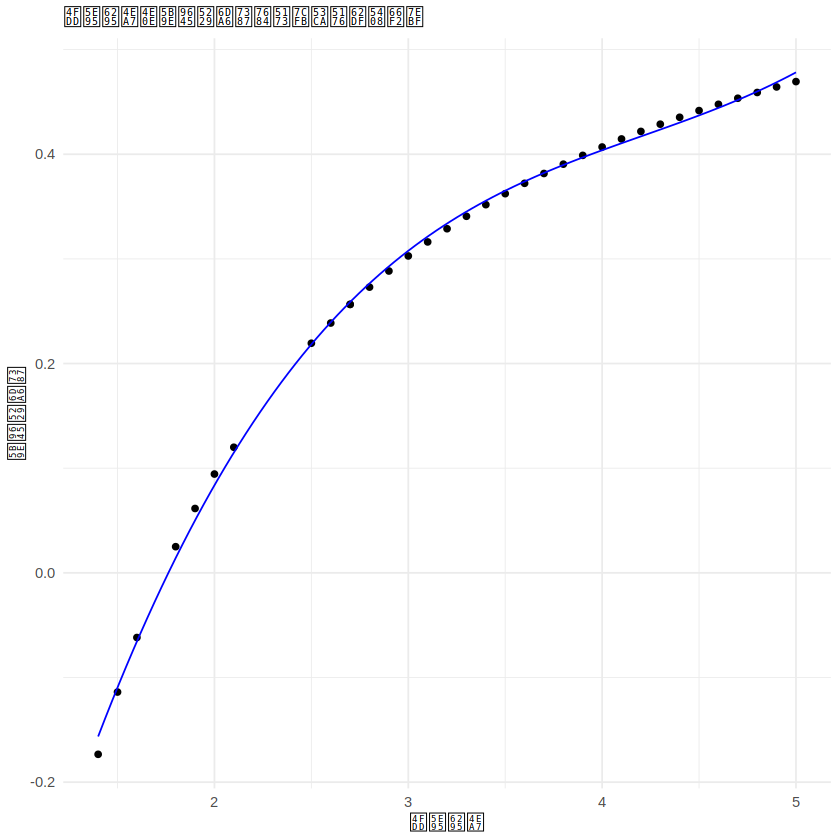

In [60]:
# Assuming your data is in a dataframe called 'data_10' with columns '保底投产' and '实际利润率'

# Fit a polynomial model (change the degree as necessary)
fit <- lm(实际利润率 ~ poly(保底投产, 3), data = data_10)

# Create a dataframe for predictions
pred_data <- data.frame(保底投产 = seq(min(data_10$保底投产), max(data_10$保底投产), length.out = 100))
pred_data$实际利润率_pred <- predict(fit, newdata = pred_data)

# Plot the original data and the fitted curve
ggplot(data_10, aes(x = 保底投产, y = 实际利润率)) +
    geom_point() +
    geom_line(data = pred_data, aes(x = 保底投产, y = 实际利润率_pred), color = "blue") +
    theme_minimal() +
    labs(title = "保底投产与实际利润率的关系及其拟合曲线",
         x = "保底投产",
         y = "实际利润率")

[1] "Elbow point at x: 3.1981981981982 y: 26.9432479551334"


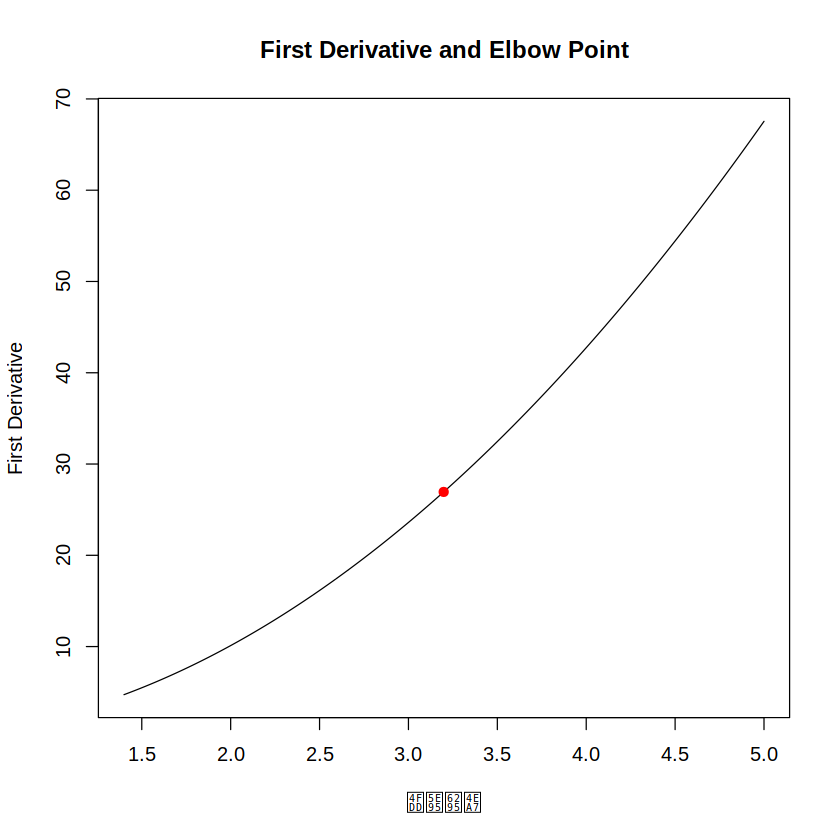

In [63]:
# Assuming 'fit' is your fitted polynomial model from the previous steps

# Get coefficients of the polynomial
coefs <- coef(fit)

# Define the first derivative function of the polynomial
first_derivative <- function(x) {
  3 * coefs[2] * x^2 + 2 * coefs[3] * x + coefs[4]
}

# Evaluate the first derivative over a range of x values
x_values <- seq(min(data_10$保底投产), max(data_10$保底投产), length.out = 1000)
deriv_values <- sapply(x_values, first_derivative)

# Function to calculate distance from a point to a line (start and end points of the derivative curve)
line_dist <- function(x, y, x1, y1, x2, y2) {
  abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / sqrt((y2 - y1)^2 + (x2 - x1)^2)
}

# Start and end points of the derivative curve
x_start <- min(x_values)
y_start <- first_derivative(x_start)
x_end <- max(x_values)
y_end <- first_derivative(x_end)

# Calculate distances of each point on the derivative curve from the line
distances <- mapply(line_dist, x_values, deriv_values, MoreArgs = list(x1 = x_start, y1 = y_start, x2 = x_end, y2 = y_end))

# Find the elbow point: the point with the maximum distance
elbow_index <- which.max(distances)
elbow_point <- c(x_values[elbow_index], deriv_values[elbow_index])

print(paste("Elbow point at x:", elbow_point[1], "y:", elbow_point[2]))

# Plotting the first derivative and the elbow point
plot(x_values, deriv_values, type='l', main="First Derivative and Elbow Point",
     xlab="保底投产", ylab="First Derivative")
points(elbow_point[1], elbow_point[2], col="red", pch=19)

# 数据分析与模型拟合总结报告

## 目标
本次分析的主要目标是研究给定数据集中“保底投产”与“实际利润率”的关系。我们的目标包括：

1. **模型拟合**：使用多项式回归模型拟合“保底投产”与“实际利润率”之间的关系。
2. **趋势分析**：通过模型分析两者之间的关系，并预测未来的走势。
3. **关键点识别**：找出数据中的拐点和第一导数的肘点，这些点在经济学或商业决策中往往具有特别的意义。

## 方法与发现

1. **多项式回归拟合**：利用三次多项式回归模型对数据进行了拟合。该模型展示了“保底投产”与“实际利润率”之间的复杂非线性关系。
3. **拐点分析**：通过计算多项式的第一导数，并分析其变化，我们成功识别了数据中的拐点。这些拐点可能表明了“保底投产”对“实际利润率”的影响在这些点发生了显著变化。
4. **肘点识别**：我们进一步找到了第一导数曲线的肘点，这代表了导数曲线变化趋势中最显著的点。该点对于理解市场动态和作出战略决策可能非常关键。

## 结论
本次分析提供了对“保底投产”与“实际利润率”关系的深入理解，并揭示了其中的关键变化点。通过多项式模型，我们不仅捕捉到了数据的复杂关系，还能够预测未来的走势。拐点和肘点的识别对于商业决策和经济分析具有重要价值。然而，需要注意的是，所有预测都建立在当前趋势持续的假设之上，实际情况可能会因多种因素而有所不同。

## 本人建议
本次数据还是具有局限性，中间出现了空白的数据段可能会影响分析结果。我推荐将保底投产设置为: 3.1981981981982，实际利润率为: 26.9432479551334时，投入的资金和实际利润率可达到相对最大化，以及风险最小化。